In [213]:
import pickle, re
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.geometry as geo
import pandas as pd
import numpy as np
import sys
import t651.authorities as authorities
from t651.authorities import *
import importlib
importlib.reload(libero)


<module 't651.authorities.libero' from 'C:\\Projects\\other\\ch-pt-utils\\preparation\\t651\\authorities\\libero.py'>

In [56]:

def read_stations(authorities_path):
    print("Loading stations ...")
    stations = []

    stations += authorities.awelle.read("%s/t651.awelle.txt" % authorities_path)

    stations += authorities.engadin_mobil.read("%s/t651.engadin_mobil.txt" % authorities_path)

    stations += authorities.frimobil.read("%s/t651.frimobil.txt" % authorities_path)

    stations += authorities.libero.read("%s/t651.libero.txt" % authorities_path)

    stations += authorities.ostwind.read("%s/t651.ostwind.txt" % authorities_path)

    stations += authorities.mobilis.read("%s/t651.mobilis.xls" % authorities_path)

    stations += authorities.ondeverte.read("%s/t651.ondeverte.txt" % authorities_path)

    stations += authorities.passepartout.read("%s/t651.passepartout.txt" % authorities_path)

    stations += authorities.transreno.read("%s/t651.transreno.txt" % authorities_path)

    stations += authorities.tvsz.read("%s/t651.tvsz.docx" % authorities_path)

    stations += authorities.tvzg.read("%s/t651.tvzg.txt" % authorities_path)

    stations += authorities.unireso.read("%s/t651.unireso.txt" % authorities_path)

    stations += authorities.zvv.read("%s/t651.zvv.txt" % authorities_path)

    df_stations = []

    for station_name, station_zones, station_authority in stations:
        for station_zone in station_zones:
            df_stations.append([station_name, station_zone, station_authority])

    df_stations = pd.DataFrame.from_records(
        df_stations,
        columns = ["station_name", "station_zone", "station_authority"]
    )
    df_stations["station_id"] = np.arange(len(df_stations))
    
    df_stations["x"] = np.nan
    df_stations["y"] = np.nan
    
    return df_stations

def read_hafas(hafas_path):
    print("Reading HAFAS ...")
    df_hafas = []

    with open("%s/BFKOORD_GEO" % hafas_path, encoding='utf-8') as f:
        for line in f:
            parts = line.split("%")
            data = re.split(r'[ ]+', parts[0])

            hafas_name = parts[1].strip()
            hafas_id = int(data[0])
            hafas_geometry = geo.Point(float(data[1]), float(data[2]))

            df_hafas.append([hafas_id, hafas_name, hafas_geometry])

    df_hafas = pd.DataFrame.from_records(
        df_hafas,
        columns =  ["hafas_id", "hafas_name", "geometry"]
    )

    df_hafas = gpd.GeoDataFrame(df_hafas, crs = {"init" : "EPSG:4326"})
    df_hafas = df_hafas.to_crs({ "init" : "EPSG:2056" })
    return df_hafas

In [214]:
stations = authorities.frimobil.read("%s/t651.frimobil.txt" % "../pt_data/t651")
stations += authorities.libero.read("%s/t651.libero.txt" % "../pt_data/t651")

df_stations1 = []

for station_name, station_zones, station_authority in stations:
    for station_zone in station_zones:
        df_stations1.append([station_name, station_zone, station_authority])

df_stations1 = pd.DataFrame.from_records(
    df_stations1,
    columns = ["station_name", "station_zone", "station_authority"]
)

df_stations = df_stations.drop(df_stations[df_stations.station_authority == 'Libero'].index)
df_stations = df_stations.drop(df_stations[df_stations.station_authority == 'Frimobil'].index)
df_stations = pd.concat([df_stations, df_stations1], ignore_index=True, sort=False)

#df_stations["station_id"] = np.arange(len(df_stations))


In [216]:
df_stations[df_stations.station_name.str.contains("München")]

,Coordinates,station_authority,station_id_x,station_id_y,station_name,station_zone,x,y
17702,NaN,Frimobil,NaN,NaN,"Münchenwiler, Bahnhof",50,NaN,NaN
17703,NaN,Frimobil,NaN,NaN,"Münchenwiler, Dorf",50,NaN,NaN
17704,NaN,Frimobil,NaN,NaN,Münchenwiler - Courgevaux,50,NaN,NaN
19679,NaN,Libero,NaN,NaN,Münchenbuchsee,114,NaN,NaN
19680,NaN,Libero,NaN,NaN,"Münchenbuchsee, Buechlimatt",114,NaN,NaN
19681,NaN,Libero,NaN,NaN,"Münchenbuchsee, Coop",114,NaN,NaN
19682,NaN,Libero,NaN,NaN,"Münchenbuchsee, Hofwilstrasse",114,NaN,NaN
19683,NaN,Libero,NaN,NaN,"Münchenbuchsee, Hüslimoos",114,NaN,NaN
19684,NaN,Libero,NaN,NaN,"Münchenbuchsee, Kipfgasse",114,NaN,NaN
19685,NaN,Libero,NaN,NaN,"Münchenbuchsee, Kirche",114,NaN,NaN


In [66]:
 hafas_path = "../pt_data/hafas"
authorities_path = "../pt_data/t651"
output_path = "../pt_data/output/"

# Read input data
df_hafas = read_hafas(hafas_path)
df_stations = read_stations(authorities_path)
# Merge by name
print("Merging ...")
df_merge = pd.merge(
    df_hafas, df_stations,
    left_on = "hafas_name", right_on = "station_name",
    how = "left"
)

# Some of the merging doesn't work. Here are those that cannot be matched
# and would need to be fixed.

all_ids = set(df_stations["station_id"])
matched_ids = set(df_merge["station_id"].dropna())
missing_ids = all_ids - matched_ids

df_errors = df_stations[df_stations["station_id"].isin(missing_ids)]

print("Stations loaded: %d" % len(df_stations))

print("Stations with zones that could not be matched: %d (%.2f%%)" % (
    len(missing_ids), 100.0 * len(missing_ids) / len(all_ids)
))

Reading HAFAS ...
Loading stations ...
('Agriswil', [56])
('Albeuve', [22])
('Albeuve Bus', [22])
('Albligen, Dorf', [14])
('Albligen, Kurried', [14])
('Allières', [23])
('Altavilla', [50])
('Alterswil FR, Beniwil', [17])
('Alterswil FR, Dorfplatz', [17])
('Alterswil FR, Galteren', [17])
('Alterswil FR, Geriwil', [17])
('Alterswil FR, Hofmatt', [17])
('Alterswil FR, Wengliswil', [17])
('Alterswil FR, Wilersguet', [17])
('Arconciel, Pelleret', [34])
('Arconciel, Rialet', [34])
('Arconciel, Sur - le - Moulin', [34])
('Arconciel, village', [34])
('Attalens, Corcelles', [93])
('Attalens, Fin du Clos', [93])
('Attalens, La Fin', [93])
('Attalens, village', [93])
('Aumont', [85])
('Autavaux, bif.', [84])
("Autigny, Café de l'Ecu", [36])
('Autigny, En Verdau', [36])
('Autigny, Le Bas', [36])
('Avenches', [51])
('Avenches, Bibracte', [51])
('Avenches, Collège Sous - Ville', [51])
('Avenches, EMS Marc Aurèle', [51])
('Avenches, Faubourg', [51])
('Avenches, Haras Fédéral', [51])
('Avenches, Hôte

In [329]:
df_stations[df_stations['station_name'].str.contains('Ã¼')]

,station_name,station_zone,station_authority,station_id,x,y


In [5]:
df_stations[df_stations['station_name'].str.contains("Calais")]

,station_name,station_zone,station_authority,station_id


In [6]:
len(df_stations)

16074

(5.955912441171385, 45.81797560634117, 10.49205074786452, 47.8084567315638)

In [16]:
swiss_unmatched_hafas_df

,hafas_id,hafas_name,geometry
4,7,"Fideris, Bahnhof",POINT (2774787.186445599 1199364.20962458)
7,11,Grenchen,POINT (2596274.493618085 1226762.572586295)
11,22,Basel,POINT (2611362.608794126 1266308.486241473)
12,24,Bern Bümpliz,POINT (2596695.017399477 1198488.727416282)
14,28,Boudry TN,POINT (2554347.991004538 1200008.969164675)
18,35,Lothenbach,POINT (2680552.935714622 1218725.015317231)
19,36,Lothenbach (See),POINT (2680552.935714622 1218725.015317231)
28,59,Tägerwilen,POINT (2727270.262834117 1280149.223096727)
33,85,Schönbühl,POINT (2604584.426880339 1207544.382320503)
34,88,Blatten LBB,POINT (2641949.954445942 1134347.963250368)


In [15]:
# Some of the merging doesn't work. Here are those that cannot be matched
# and would need to be fixed.

all_ids = set(df_stations["station_id"])
matched_ids = set(df_merge["station_id"].dropna())
missing_ids = all_ids - matched_ids

df_errors = df_stations[df_stations["station_id"].isin(missing_ids)]

print("Stations with zones that could not be matched: %d (%.2f%%)" % (
    len(missing_ids), 100.0 * len(missing_ids) / len(all_ids)
))

# Impute zones

# Here we create convex hulls for all (zone, authority) pairs and find a zone
# for all unmatched HAFAS ids via spatial join.

df_convex_hulls = gpd.GeoDataFrame(df_merge.dropna().groupby([
    "station_authority", "station_zone"
])["geometry"].agg(
    lambda group: geo.MultiPoint(list(group.values)).convex_hull if len(group.values) > 3 else None
).reset_index(name = "geometry")).dropna()
df_convex_hulls.crs = {"init" : "EPSG:2056"}

df_missing = df_merge[df_merge["station_name"].isna()][["hafas_id", "hafas_name", "geometry"]]
df_spatial_merge = gpd.sjoin(df_missing, df_convex_hulls, op = "within")

print("HAFAS stations matched by spatial merge: %d" % len(df_spatial_merge))

# Cleanup

df_spatial_merge["imputed"] = 1
df_merge["imputed"] = 0

df_merge = df_merge[~df_merge["hafas_id"].isin(df_spatial_merge["hafas_id"])]
df_merge = df_merge[["hafas_id", "hafas_name", "station_zone", "station_authority", "imputed", "geometry"]]
df_spatial_merge = df_spatial_merge[["hafas_id", "hafas_name", "station_zone", "station_authority", "imputed", "geometry"]]
df_merge = pd.concat([df_merge, df_spatial_merge])

assert(len(np.unique(df_merge["hafas_id"])) == len(np.unique(df_hafas["hafas_id"])))
df_merge.columns = ["hafas_id", "hafas_name", "zone_id", "authority_id", "imputed", "geometry"]

# Output shape file
print("Writing HAFAS shape file ...")
df_merge.to_file("%s/t651.hafas_mapped.shp" % output_path)

# Output convex hulls
print("Writing convex hulls shape file ...")
df_convex_hulls.to_file("%s/t651.convex_hulls.shp" % output_path)

# Output routing information
print("Writing csv ...")
df_output = df_merge[["hafas_id", "zone_id", "authority_id", "imputed"]].dropna()
df_output["zone_id"] = df_output["zone_id"].astype(np.int)
df_output["imputed"] = df_output["imputed"].astype(np.bool)
df_output.to_csv("%s/t651.csv" % output_path, sep = ";", index = None)

Stations with zones that could not be matched: 4446 (34.32%)
HAFAS stations matched by spatial merge: 7309
Writing HAFAS shape file ...


c:\users\molloyj\appdata\local\programs\python\python37\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


Writing convex hulls shape file ...
Writing csv ...


In [34]:
df_stations[df_stations.station_name == 'Florissant']

,station_name,station_zone,station_authority,station_id,x,y
14881,Florissant,10,Unireso,14198,500816.0,116981.0
14882,Florissant,10,Unireso,14198,500816.0,116981.0
14883,Florissant,10,Unireso,14199,500816.0,116981.0
14884,Florissant,10,Unireso,14199,500816.0,116981.0
15485,Florissant,82,Unireso,14773,507590.0,116824.0


In [31]:
manual_stations = pd.read_excel("unmatched_stations_manual.xlsx").set_index('station_name')

In [35]:
import requests

def handle_unireso_france(row):
    if (row.station_zone == 82):
        station_name = row.station_name
        if (station_name == 'Acacias'):
            r = requests.get('https://timetable.search.ch/api/completion.json?show_coordinates=true&show_ids=true&term={}'.format('Annemasse'))
            res = r.json() 
        else:
            r = requests.get('https://timetable.search.ch/api/completion.json?show_coordinates=true&show_ids=true&term={}'.format('Galliard, ' + station_name))
            res = r.json() 
        if len(res) == 0:
            r = requests.get('https://timetable.search.ch/api/completion.json?show_coordinates=true&show_ids=true&term={}'.format('Annemasse, ' + station_name))
            res = r.json()  
        if len(res) == 0:
            r = requests.get('https://timetable.search.ch/api/completion.json?show_coordinates=true&show_ids=true&term={}'.format('Ambilly, ' + station_name))
            res = r.json() 
        if len(res) == 0:
            r = requests.get('https://timetable.search.ch/api/completion.json?show_coordinates=true&show_ids=true&term={}'.format('Annemasse'))
            res = r.json() 
        if len(res) == 0 and station_name in manual_stations.index:
            trimmed_station_name = manual_stations.loc[station_name, 'manual_name']
            r = requests.get('https://timetable.search.ch/api/completion.json?show_coordinates=true&show_ids=true&term={}'.format(trimmed_station_name))
            res = r.json() 
        if len(res) == 0:
            r = requests.get('https://timetable.search.ch/api/completion.json?show_coordinates=true&show_ids=true&term={}'.format(station_name))
            res = r.json() 
    
        return res
    else:
        return []

station_name = 'Florissant'
rows = df_stations[df_stations.station_name == station_name].itertuples()
for row in rows:
    res = handle_unireso_france(row)   
    print(station_name in manual_stations.index)
    print (res)

False
[]
False
[]
False
[]
False
[]
False
[{'label': 'Annemasse, Florissant', 'id': '8595783', 'x': '507590', 'y': '116824', 'iconclass': 'sl-icon-type-bus', 'html': '<span class="sl-keyword">Annemasse</span>, <span class="sl-keyword">Florissant</span>'}]


In [92]:
print (df_stations.loc[ (df_stations.x.isna())].groupby('station_authority').size())

station_authority
EngadinMobil     4
Frimobil         4
Libero           5
Mobilis          3
Ostwind         26
TVSZ             1
TVZG            24
Unireso         87
ZVV              5
dtype: int64


In [217]:
import requests

not_found_api = set()
 
def get_station_location(row):
    station_name = row.station_name
    if np.isnan(row.x): # or len(station_name.split(', ')) > 1:
        if row.station_authority == 'Unireso' and row.station_zone == 82:
            res = handle_unireso_france(row)   
            trimmed_station_name = station_name
        else:  
            if station_name in manual_stations.index:
                trimmed_station_name = manual_stations.loc[station_name, 'manual_name']
                print ("try " + trimmed_station_name)                                                                              
            else:
                trimmed_station_name = (station_name.replace('.RVBW', "").replace('RVBW', "")
                                        .replace(", Ab.Winters.", "").replace(" RBL", "")
                                        .replace(' BGU', "").replace(' RBS', "")
                                        .replace(' i.E.', "").replace(' CJ A', "")
                                        .replace(', Schiffstation', "").replace('Bhf', "Bahnhof")
                                        .replace('BAAR SCHMITTLI', 'BAAR')
                                        .replace('ZIHLBRÜCKE GARE', 'ZIHLBRÜCKE')
                                       )
                
                if 'BAAR' in trimmed_station_name:
                    trimmed_station_name = 'BAAR'
                
                elif " PAG" in trimmed_station_name:
                    trimmed_station_name = trimmed_station_name.split("   ")[0]
                    
            r = requests.get('https://timetable.search.ch/api/completion.json?show_coordinates=true&show_ids=true&term={}'.format(trimmed_station_name))
            res = [rr for rr in r.json() if 'x' in rr]
            
        if len(res) == 0 and len(station_name.split(', ')) > 1:
            trimmed_station_name = trimmed_station_name.split(', ')[0]
            r = requests.get('https://timetable.search.ch/api/completion.json?show_coordinates=true&show_ids=true&term={}'.format(trimmed_station_name))
            res = [rr for rr in r.json() if 'x' in rr]
                                                                                                
        if len(res) > 0 and 'x' in res[0]:
            
            print ("Result found for {}, {} | {}".format(row.station_name, row.station_authority, trimmed_station_name))

            
            station_res = filtered_dict = {k:v for (k,v) in res[0].items() if k in ['label', 'id', 'x', 'y']}
            #locations.update({station_name : station_res})
            df_stations.at[row.Index, 'x'] = res[0]['x']
            df_stations.at[row.Index, 'y'] = res[0]['y']
        else:    
                
            #print ("No result found for {}, {} | {}".format(row.station_name, row.station_authority, trimmed_station_name))
            not_found_api.add(station_name)
        
for row in df_stations.itertuples():
    get_station_location(row) 
    if len(locations) % 1000 == 0:
        print ("temp save at {}".format(len(locations)))
        with open('locations_sbb.p', 'wb') as fp:
            pickle.dump(locations, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('locations_sbb.p', 'wb') as fp:
    pickle.dump(locations, fp, protocol=pickle.HIGHEST_PROTOCOL)
      

#for s in not_found_api:
#    get_station_location(s) 

try Gailingen
try Gailingen
try Gailingen
try Gailingen
try Geisslingen
try Geisslingen
try Istighofen
try Lottstetten/Rafz
try Nack
try Niederaach
try Ohningen
try Tannenbodenalp
try Weisweil
try Weisweil
try bavois gare
try MSA, Dépôt
try La Bécassière
Result found for Agriswil, Frimobil | Agriswil
Result found for Albeuve, Frimobil | Albeuve
Result found for Albligen, Dorf, Frimobil | Albligen, Dorf
Result found for Albligen, Kurried, Frimobil | Albligen, Kurried
Result found for Allières, Frimobil | Allières
Result found for Altavilla, Frimobil | Altavilla
Result found for Alterswil FR, Beniwil, Frimobil | Alterswil FR, Beniwil
Result found for Alterswil FR, Dorfplatz, Frimobil | Alterswil FR, Dorfplatz
Result found for Alterswil FR, Galteren, Frimobil | Alterswil FR, Galteren
Result found for Alterswil FR, Geriwil, Frimobil | Alterswil FR, Geriwil
Result found for Alterswil FR, Hofmatt, Frimobil | Alterswil FR, Hofmatt
Result found for Alterswil FR, Wengliswil, Frimobil | Alterswi

In [182]:
#handle tricky ondeverte stations
ov_na_stations = df_stations.loc[ (df_stations.x.isna() ) & (df_stations.station_authority == 'OndeVerte')]
for row in ov_na_stations.itertuples():
    print ("geolocating: " + row.station_name)
    trimmed_station_name = station_name = row.station_name.replace("GARE", "")
    print ("\ttry: " + trimmed_station_name)

    r = requests.get('https://timetable.search.ch/api/completion.json?show_coordinates=true&show_ids=true&term={}'.format(trimmed_station_name))
    res = [rr for rr in r.json() if 'x' in rr]
    
    if len(res) == 0:
        sp = trimmed_station_name.split(" ")
        if (len(sp[0]) <= 3):
            trimmed_station_name = sp[0] + ' ' + sp[1]
        else:
            trimmed_station_name = sp[0]
        print ("\ttry: " + trimmed_station_name)

        r = requests.get('https://timetable.search.ch/api/completion.json?show_coordinates=true&show_ids=true&term={}'.format(trimmed_station_name))
        res = [rr for rr in r.json() if 'x' in rr]     
    
    if len(res) == 0:
        trimmed_station_name = trimmed_station_name.split("-")[0]
        print ("\ttry: " + trimmed_station_name)
        
        r = requests.get('https://timetable.search.ch/api/completion.json?show_coordinates=true&show_ids=true&term={}'.format(trimmed_station_name))
        res = [rr for rr in r.json() if 'x' in rr]    
        
    if len(res) > 0 and 'x' in res[0]:       
        print ("Result found for {}, {} | {}".format(row.station_name, row.station_authority, trimmed_station_name))
        df_stations.at[row.Index, 'x'] = res[0]['x']
        df_stations.at[row.Index, 'y'] = res[0]['y']  

geolocating: LES BREULEUX ECOLE
	try: LES BREULEUX ECOLE
	try: LES BREULEUX
Result found for LES BREULEUX ECOLE, OndeVerte | LES BREULEUX
geolocating: LES BREULEUX HAUT-DU-VILLAGE
	try: LES BREULEUX HAUT-DU-VILLAGE
	try: LES BREULEUX
Result found for LES BREULEUX HAUT-DU-VILLAGE, OndeVerte | LES BREULEUX
geolocating: LES BREULEUX LE ROSELET
	try: LES BREULEUX LE ROSELET
	try: LES BREULEUX
Result found for LES BREULEUX LE ROSELET, OndeVerte | LES BREULEUX
geolocating: LES EMIBOIS ECOLE
	try: LES EMIBOIS ECOLE
	try: LES EMIBOIS
Result found for LES EMIBOIS ECOLE, OndeVerte | LES EMIBOIS
geolocating: LES GENEVEYS-S C BELLEVUE
	try: LES GENEVEYS-S C BELLEVUE
	try: LES GENEVEYS-S
Result found for LES GENEVEYS-S C BELLEVUE, OndeVerte | LES GENEVEYS-S
geolocating: LES GENEVEYS-SUR-COFFRANE, PRÉLETS
	try: LES GENEVEYS-SUR-COFFRANE, PRÉLETS
	try: LES GENEVEYS-SUR-COFFRANE,
Result found for LES GENEVEYS-SUR-COFFRANE, PRÉLETS, OndeVerte | LES GENEVEYS-SUR-COFFRANE,
geolocating: LES JOUX-DERRIERE 

In [183]:

df_stations.at[df_stations.loc[ (df_stations.x == 539100)].index, 'x'] = np.nan
df_stations.loc[ (df_stations.x == 539100)]

,Coordinates,station_authority,station_id_x,station_id_y,station_name,station_zone,x,y


In [168]:
ov_na_stations = df_stations.loc[ (df_stations.station_name.str.contains('GARE CFF')) & (df_stations.station_authority == 'OndeVerte')]

for row in ov_na_stations.itertuples():
    print ("geolocating: " + row.station_name)
    trimmed_station_name = station_name = row.station_name.replace("GARE CFF", "")
    print ("\ttry: " + trimmed_station_name)

    r = requests.get('https://timetable.search.ch/api/completion.json?show_coordinates=true&show_ids=true&term={}'.format(trimmed_station_name))
    res = [rr for rr in r.json() if 'x' in rr]
    
    if len(res) == 0:
        sp = trimmed_station_name.split(" ")
        if (len(sp[0]) == 2):
            trimmed_station_name = sp[0] + ' ' + sp[1]
        else:
            trimmed_station_name = sp[0]
        print ("\ttry: " + trimmed_station_name)

        r = requests.get('https://timetable.search.ch/api/completion.json?show_coordinates=true&show_ids=true&term={}'.format(trimmed_station_name))
        res = [rr for rr in r.json() if 'x' in rr]     
    
    if len(res) == 0:
        trimmed_station_name = trimmed_station_name.split("-")[0]
        print ("\ttry: " + trimmed_station_name)
        
        r = requests.get('https://timetable.search.ch/api/completion.json?show_coordinates=true&show_ids=true&term={}'.format(trimmed_station_name))
        res = [rr for rr in r.json() if 'x' in rr]    
        
    if len(res) > 0 and 'x' in res[0]:       
        print ("Result found for {}, {} | {}".format(row.station_name, row.station_authority, trimmed_station_name))
        df_stations.at[row.Index, 'x'] = res[0]['x']
        df_stations.at[row.Index, 'y'] = res[0]['y']  
    else:
        print("res not found for " + row)

geolocating: LES BAYARDS GARE CFF
	try: LES BAYARDS 
Result found for LES BAYARDS GARE CFF, OndeVerte | LES BAYARDS 
geolocating: LES HAUTS-GENEVEYS GARE CFF
	try: LES HAUTS-GENEVEYS 
Result found for LES HAUTS-GENEVEYS GARE CFF, OndeVerte | LES HAUTS-GENEVEYS 
geolocating: LES HAUTS-GENEVEYS GARE CFF
	try: LES HAUTS-GENEVEYS 
Result found for LES HAUTS-GENEVEYS GARE CFF, OndeVerte | LES HAUTS-GENEVEYS 
geolocating: LES VERRIERES GARE CFF
	try: LES VERRIERES 
Result found for LES VERRIERES GARE CFF, OndeVerte | LES VERRIERES 
geolocating: NEUCHATEL GARE CFF
	try: NEUCHATEL 
Result found for NEUCHATEL GARE CFF, OndeVerte | NEUCHATEL 
geolocating: NEUCHATEL GARE CFF
	try: NEUCHATEL 
Result found for NEUCHATEL GARE CFF, OndeVerte | NEUCHATEL 
geolocating: NEUCHATEL GARE CFF
	try: NEUCHATEL 
Result found for NEUCHATEL GARE CFF, OndeVerte | NEUCHATEL 
geolocating: ST-BLAISE GARE CFF
	try: ST-BLAISE 
Result found for ST-BLAISE GARE CFF, OndeVerte | ST-BLAISE 
geolocating: ST-BLAISE-SENTIER G

In [228]:
df_stations.loc[df_stations.station_name.str.match(r'\d+')]

,Coordinates,station_authority,station_id_x,station_id_y,station_name,station_zone,x,y
11460,POINT (501471 117497),Unireso,13923.0,13907.0,31 Décembre,10,501471.0,117497.0
11501,POINT (nan nan),Unireso,13958.0,NaN,10.12.2017,69,NaN,NaN
11604,POINT (nan nan),Unireso,14055.0,NaN,10.12.2017,71,NaN,NaN
11713,POINT (nan nan),Unireso,14157.0,NaN,10.12.2017,73,NaN,NaN
11827,POINT (nan nan),Unireso,14249.0,NaN,10.12.2017,75,NaN,NaN
11931,POINT (nan nan),Unireso,14341.0,NaN,10.12.2017,77,NaN,NaN
12055,POINT (nan nan),Unireso,14438.0,NaN,10.12.2017,79,NaN,NaN
12154,POINT (nan nan),Unireso,14530.0,NaN,10.12.2017,81,NaN,NaN
12250,POINT (nan nan),Unireso,14622.0,NaN,10.12.2017,83,NaN,NaN
12362,POINT (nan nan),Unireso,14718.0,NaN,10.12.2017,85,NaN,NaN


In [253]:
df_stations = df_stations.drop(df_stations[df_stations.station_name == 'Zone'].index)
df_stations = df_stations.drop(df_stations[df_stations.station_name == 'Fellsen'].index)
df_stations = df_stations.drop(df_stations[df_stations.station_name == ''].index)
df_stations = df_stations.drop(df_stations[df_stations.station_name.str.contains('Bühl')].index)
df_stations = df_stations.drop(df_stations[df_stations.station_name.str.match(r'\d+')].index)

df_stations = df_stations.drop(df_stations[df_stations.station_name.str.contains('St.Pelagiberg') & (df_stations.station_zone == 271)].index)


manaul_edits = [['Felsenegg', 680756.66, 240447.46],
 ['THIELLE-MONTMIRAL',567450,206539 ],
 ['TROIS-COMMUNES',567450,206539 ],
 ['Maison - Rouge',501030, 117435 ],
 ['LES VERRIERES GARE CFF', 526901, 195333 ],
 ['Hôtel - de - Ville', 500367, 117489],
 ['Saint - Loup', 501011, 126502 ],
 ['Corsier - Village', 505310, 124680 ],
 ['Beau-Séjour',  500514, 116074],
 ['Bois - Gentil', 498806, 118624 ],
 ['Lully - Village', 494411, 113313],
 ['LE GRENIER', 554174, 216731],
 ['Rosé', 571137, 181310],
 ['LA VUE DES ALPES', 559131, 210321],
 ['Pont - la - Ville', 574951, 172214],
 ['P+R', np.nan, np.nan],
 ['Rue, village', 552642, 159877],
 ['LES GENEVEYS-S C MONT-RACINE', 555488, 207282],
 ['Lueg', 619816, 213574],
 ['Lamperswil, Illharterstrasse', 720288, 275008],
 ['Lamperswil, Illharterstrasse', 720288, 275008],
 ['Wilen', 739036, 248838],
 ['Kreuzstrasse', 756192, 248768],
 ['Berg', 729792, 271520]
                
]

for edit in manaul_edits:
    df_stations.at[df_stations[df_stations.station_name == edit[0]].index, 'x'] = edit[1]
    df_stations.at[df_stations[df_stations.station_name == edit[0]].index, 'y'] = edit[2]

#[680756.66
#240447.46

In [255]:


df_stations['Coordinates'] = list(zip(df_stations.x, df_stations.y))
df_stations['Coordinates'] = df_stations[  'Coordinates'].apply(geo.Point)
df_stations['authority_zone'] = df_stations['station_authority'] + "_" + df_stations['station_zone'].map(str)
locations_df = gpd.GeoDataFrame(df_stations, geometry='Coordinates')
locations_df.crs = {'init' :'epsg:21781'}
locations_df = locations_df[df_stations.x.notnull()]
locations_df.to_file("located_stations.geojson", driver='GeoJSON')


In [254]:
df_stations[df_stations.station_name.str.contains('St.Pelagiberg') & (df_stations.station_zone == 271)]

,Coordinates,station_authority,station_id_x,station_id_y,station_name,station_zone,x,y,authority_zone


ValueError: 'c' argument must either be valid as mpl color(s) or as numbers to be mapped to colors. Here c = [('AWelle', array([0.267004, 0.004874, 0.329415, 1.      ])), ('EngadinMobil', array([0.283229, 0.120777, 0.440584, 1.      ])), ('Frimobil', array([0.267968, 0.223549, 0.512008, 1.      ])), ('Libero', array([0.229739, 0.322361, 0.545706, 1.      ])), ('Ostwind', array([0.190631, 0.407061, 0.556089, 1.      ])), ('Mobilis', array([0.157729, 0.485932, 0.558013, 1.      ])), ('OndeVerte', array([0.127568, 0.566949, 0.550556, 1.      ])), ('Passepartout', array([0.126326, 0.644107, 0.525311, 1.      ])), ('TransReno', array([0.20803 , 0.718701, 0.472873, 1.      ])), ('TVSZ', array([0.369214, 0.788888, 0.382914, 1.      ])), ('TVZG', array([0.565498, 0.84243 , 0.262877, 1.      ])), ('Unireso', array([0.783315, 0.879285, 0.125405, 1.      ])), ('ZVV', array([0.993248, 0.906157, 0.143936, 1.      ]))].

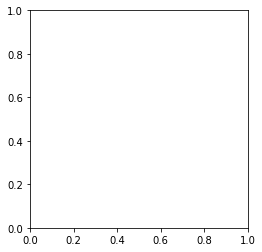

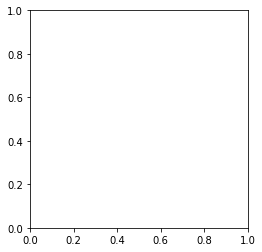

In [414]:
cmap = plt.get_cmap('viridis')
authorities = locations_df.station_authority.unique()
colors = cmap(np.linspace(0, 1, len(authorities)))
auth_colors = list(zip(authorities, colors))
auth_colors

locations_df.groupby('station_authority').plot(c=auth_colors)

In [106]:
#match stations to hafas
switzerland_shp = gpd.read_file("../pt_data/swiss_shapefile/").to_crs({'init': 'epsg:2056'})
swiss_outline = switzerland_shp.unary_union
swiss_hafas_df = df_hafas[df_hafas.apply(lambda x: x.geometry.within(swiss_outline.envelope) & x.geometry.within(swiss_outline), axis=1)]

In [19]:
import json

from shapely.geometry import shape

def load_located_stations_geojson:
    with open('located_stations.geojson') as f:
        locations = json.load(f)['features']

    for d in locations:
        d['geometry'] = shape(d['geometry'])
        d.update(d['properties'])
        d.pop('properties')
        d.pop('type')


    return gpd.GeoDataFrame(locations)


,geometry,station_authority,station_id,station_name,station_zone,x,y
0,POINT (2646255.040351061 1249126.945687531),AWelle,0,Aarau,510,646255.0,249127.0
1,POINT (2648785.040355812 1250485.945689935),AWelle,1,"Aarau Rohr, Gemeindehaus",510,648785.0,250486.0
2,POINT (2648044.040354424 1250142.945689333),AWelle,2,"Aarau Rohr, Quellhölzli",510,648044.0,250143.0
3,POINT (2648459.040355201 1250333.945689667),AWelle,3,"Aarau Rohr, Rigistrasse",510,648459.0,250334.0
4,POINT (2647824.040354006 1249936.945688964),AWelle,4,"Aarau Rohr, Salamatt",510,647824.0,249937.0
5,POINT (2649010.040356234 1250604.945690142),AWelle,5,"Aarau Rohr, Unterdorf",510,649010.0,250605.0
6,POINT (2647111.040352658 1249379.945687961),AWelle,6,Aarau Torfeld,510,647111.0,249380.0
7,POINT (2646085.040350801 1250260.945689646),AWelle,7,"Aarau, Aarenau",510,646085.0,250261.0
8,POINT (2645500.040349688 1249675.945688594),AWelle,8,"Aarau, Aarepark",510,645500.0,249676.0
9,POINT (2645906.04035046 1250075.945689314),AWelle,9,"Aarau, Achenbergstrasse",510,645906.0,250076.0


In [105]:
swiss_hafas_df.to_crs

,hafas_id,hafas_name,geometry
0,2,Bucuresti,POINT (4070575.598513067 1096469.251580726)
1,3,Calais,POINT (2203533.465450717 1653944.174845859)
2,4,Canterbury,POINT (2155238.437024752 1700468.157544516)
3,5,Exeter,POINT (1825306.089449643 1674873.037213882)
4,7,"Fideris, Bahnhof",POINT (2774787.186445599 1199364.20962458)
5,8,Frankfurt Flughafen,POINT (2681238.326362874 1545492.184036746)
6,9,Gdansk,POINT (3332368.482652406 2078796.050658228)
7,11,Grenchen,POINT (2596274.493618085 1226762.572586295)
8,17,Amstetten (Württ),POINT (2779745.885584383 1383689.613121744)
9,19,Avignon,POINT (2386707.170631916 866796.1421058826)


In [240]:
locations_df.loc[(locations_df.station_name == 'Berg')]

,Coordinates,station_authority,station_id_x,station_id_y,station_name,station_zone,x,y,authority_zone
498,POINT (747208 261257),Ostwind,5444.0,5444.0,Berg,925,747208.0,261257.0,Ostwind_925


In [241]:
locations_df.loc[(locations_df.station_authority == 'Ostwind')& (locations_df.station_zone == 958) ].sort_values('y')

,Coordinates,station_authority,station_id_x,station_id_y,station_name,station_zone,x,y,authority_zone
2381,POINT (721280 254526),Ostwind,6615.0,6615.0,"Lamperswil, Illharterstrasse",958,721280.0,254526.0,Ostwind_958
2065,POINT (725732 273324),Ostwind,6395.0,6395.0,"Hugelshofen, Langgasse",958,725732.0,273324.0,Ostwind_958
2067,POINT (726146 273329),Ostwind,6397.0,6397.0,"Hugelshofen, Unterdorf",958,726146.0,273329.0,Ostwind_958
2066,POINT (726972 273341),Ostwind,6396.0,6396.0,"Hugelshofen, Schlatt",958,726972.0,273341.0,Ostwind_958
910,POINT (721513 273435),Ostwind,5731.0,5731.0,"Engwang, Dorf",958,721513.0,273435.0,Ostwind_958
829,POINT (727977 273512),Ostwind,5664.0,5664.0,"Dotnacht, Dorfplatz",958,727977.0,273512.0,Ostwind_958
4987,POINT (722213 274289),Ostwind,8157.0,8157.0,"Wagerswil, Dorf",958,722213.0,274289.0,Ostwind_958
2475,POINT (721578 274933),Ostwind,6671.0,6671.0,"Lipperswil, Conny Land",958,721578.0,274933.0,Ostwind_958
2476,POINT (721578 275161),Ostwind,6672.0,6672.0,"Lipperswil, Kellhof",958,721578.0,275161.0,Ostwind_958
1755,POINT (722120 275317),Ostwind,6247.0,6247.0,"Hefenhausen, Illharterstrasse",958,722120.0,275317.0,Ostwind_958
